# Practical Machine Learning
# Lab 4
## Neural Networks

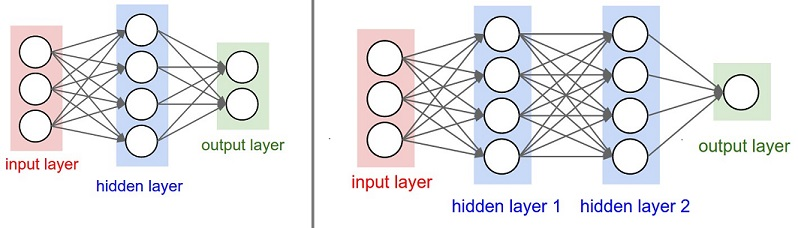
Left: A 2-layer Neural Network (one hidden layer of 4 neurons (or units) and one output layer with 2 neurons), and three inputs. Right: A 3-layer neural network with three inputs, two hidden layers of 4 neurons each and one output layer. Notice that in both cases there are connections between neurons across layers, but not within a layer.

### In order to do this lab you must have tensorflow 2.0  installed on your computer.

### We are going to classify the images from the CIFAR dataset using neural networks.

## CIFAR 

This dataset consists of 60,000 tiny images that are 32 pixels high and wide. Each image is labeled with one of 10 classes (for example “airplane, automobile, bird, etc”). These 60,000 images are partitioned into a training set of 50,000 images and a test set of 10,000 images. 

The classes are:
- 0: airplane
- 1: automobile
- 2: bird
- 3: cat
- 4: deer
- 5: dog
- 6: frog
- 7: horse
- 8: ship
- 9: truck.

Since neural network takes more time to train then the previous models you've been working with, we will choose only 1000 images per class



In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load training data
train_images_raw = np.load('data/train_images.npy')
train_labels = np.load('data/train_labels.npy') 
print('The number of images for training is %d.' % train_images_raw.shape[0])

The number of images for training is 10000.


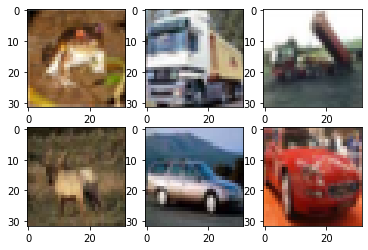

In [3]:
num_cols = 3
num_rows = 2
for i in range(num_rows):
    for j in range(num_cols):
        plt.subplot(num_rows, num_cols, i * num_cols + j + 1) 
        im = train_images_raw[i * num_cols + j].copy()  
        plt.imshow(im) 
plt.show() 

## Training a fully connected neural network in Keras

## 1. Load the data

In [4]:
# the training data is already loaded 
# load the test data
test_images_raw = np.load('data/test_images.npy')
test_labels = np.load('data/test_labels.npy') 

## 2. Prepare the data
Convert the data from uint8 to float32, normalize the pixel data from [0, 255] to [0, 1]

Compute the mean image and substract it from each training and test image.

In [5]:
# write your code here  
# TODO: 2.1 convert int to float
train_images = np.float32(train_images_raw) / 255
test_images = np.float32(test_images_raw) / 255
# TODO: 2.2 compute mean training image
mean_image = np.mean(train_images, axis=0)
# TODO: 2.3 subtract the mean image from training and test data.
# train_images -= mean_image
# test_images -= mean_image 

## 3. Build the neural network

You are going to build a neural network with 5 fully connected layers, activation function _relu_ and a dropout layer inserted before the last layer. Our last (5-th) layer has 10 units (the number of classes) and its activation function is _softmax_.

In [6]:
import tensorflow as tf 

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(32, 32, 3)), # we use this layer to flatten/vectorize the images
  tf.keras.layers.Dense(512, activation='relu'), # we add a fully connected layer with 512 units using relu as activation function
  tf.keras.layers.Dense(512, activation='relu'), # we add a fully connected layer with 512 units using relu as activation function
  tf.keras.layers.Dense(1024, activation='relu'), # we add a fully connected layer with 1024 units using relu as activation function
  tf.keras.layers.Dense(1024, activation='relu'), # we add a fully connected layer with 1024 units using relu as activation function
  tf.keras.layers.Dropout(0.4), # we add a dropout layer with the dropout rate 0.4
  tf.keras.layers.Dense(10, activation='softmax') # we add a fully connected layer with 10 units (the number of classes) using softmax as activation function
])

## 4. Compile the model
When you compile a model you should specify:
- the optimizer
    - SGD, Adam, RMSprop
    - Adam - a good optimizer for many cases. Adam adjusts the learning rate throughout training.
    - you can find more optimizers here: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers 
- the loss
    - MSE, MAE, sparse_categorical_crossentropy, BinaryCrossentropy
    - you can find more losses here: https://www.tensorflow.org/api_docs/python/tf/keras/losses   
- the metrics
    - Acurracy, Precision, Recall, MeanAbsoluteError, MeanSquaredError
    - you can find more metrics here: https://www.tensorflow.org/api_docs/python/tf/keras/metrics  

In [7]:
# import SGD and Adam optimizers 
from tensorflow.keras.optimizers import SGD, Adam, RMSprop 

# define the optimizer, set the learning rate and the momentum (for SGD with momentum)
optimizer = SGD(lr=0.001, momentum=0.9)  
# compile the model specifying the optimizer, the loss and the metrics (as an array).
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 5. Train and evaluate the model

- Create checkpoints dir, this is the directory where we save the network's weights after each epoch.

In [8]:
import os
if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints') 

- In order to save the network's weights (a checkpoint) we have to define a callback.

In [9]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = './checkpoints/model.{epoch:05d}.hdf5'
)

- We will use TensorBoard to see the metrics and the loss after each epoch.
We can specify if we want to save the values after each step or epoch using the *update_freq* parameter.
- To start tensorboard type *tensorboard --logdir=logs/train* in the current directory. The folder *logs* is the folder we pass to the *log_dir* parameter. 

In [10]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = os.path.join('logs'),  
    write_graph = True, 
    update_freq = 'epoch'
)

- Now we'll start the training using the *fit* function.
    - the first param is the training data
    - the 2nd param is the training labels
    - epochs: the number of epoch we want to train the model
    - batch_size: the number of examples for a iteration (an update step)
    - callbacks: the callbacks we want to be done
    - validation_data: we can pass a tuple with validation data and validation label
    - initial_epoch: if you want to continue the training from a specific epoch, after you restore the model, you should also specify the epoch.

In [11]:
model.fit(train_images[:-1000], train_labels[:-1000],
          epochs=10, batch_size=32, initial_epoch=0,
          callbacks=[checkpoint_callback, tensorboard_callback],
          validation_data=(train_images[-1000:], train_labels[-1000:])) 

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
1440/9000 [===>..........................] - ETA: 14s - loss: 2.2985 - accuracy: 0.1065

KeyboardInterrupt: 

- Now, we'll evaluate the model on the test data using the *evaluate* function, it returns the loss value and metrics values for the model in test mode.

- Now, you are going to open Tensorboard to see the epoch that has the best accuracy on the validation set and to restore those weights in order to evaluate the network on the testing set.

In [12]:
test_loss, test_metrics = model.evaluate(test_images, test_labels, verbose=0) 
print('test loss', test_loss)
print('test metrics', test_metrics)

test loss 2.2504981079101563
test metrics 0.1825


In [13]:
from tensorflow.keras.models import load_model 
best_epoch = 10
best_model = load_model('./checkpoints/model.%05d.hdf5' % best_epoch)
predicted_test_labels_scores = best_model.predict(test_images)
predicted_test_labels = np.argmax(predicted_test_labels_scores, axis=-1)
accuracy = np.mean(predicted_test_labels == test_labels)
print('accuracy = ', accuracy)

accuracy =  0.4265


## Exercises

## 1. Train the previous network without subtracting the mean image from data. What do  you notice in terms of accuracy and loss?

## 2. Create a network that has the following configuration:
    - L1. dense layer with 256 units and activation function relu
    - L2. dense layer with 256 units and activation function relu
    - L3. dense layer with 256 units and activation function relu 
    - L5. dense layer with 512 units and activation function relu
    - L6. dense layer with 512 units and activation function relu
    - L7. dense layer with 512 units and activation function relu 
    - L9. dense layer with 10 units and activation function softmax

Train the network for 10 epochs using gradient descent with momentum set to 0.9, learning rate set to 0.001 and save the accuracy.

Train the network for 10 epochs using Adam optimizer, learning rate set to 0.001 and save the accuracy.

As validation data use the last 1000 examples from the training set.

Which configuration worked best? 



In [15]:
# write your code here  
# 2.1 define the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(32, 32, 3)), # we use this layer to flatten/vectorize the images
  tf.keras.layers.Dense(256, activation='relu'),  
  tf.keras.layers.Dense(256, activation='relu'),  
  tf.keras.layers.Dense(256, activation='relu'),   
  tf.keras.layers.Dense(512, activation='relu'),  
  tf.keras.layers.Dense(512, activation='relu'), 
  tf.keras.layers.Dense(512, activation='relu'),  
  tf.keras.layers.Dense(10, activation='softmax') 
])

# 2.2 compile 
optimizer = Adam(lr=0.1) 
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 2.3 train the model
checkpoint_dir = './checkpoints_1'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir) 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_dir + '/model.{epoch:05d}.hdf5'
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = os.path.join('logs'),  
    write_graph = True, 
    update_freq = 'epoch'
)
model.fit(train_images[:-1000], train_labels[:-1000],
          epochs=10, batch_size=32, initial_epoch=0,
          callbacks=[checkpoint_callback, tensorboard_callback],
          validation_data=(train_images[-1000:], train_labels[-1000:])) 

# 2.4 evaluate the model 
test_loss, test_metrics = model.evaluate(test_images, test_labels, verbose=0) 
print('test loss', test_loss)
print('test metrics', test_metrics)
# test loss 1.7957262001037597 Adam
# test metrics 0.358
# test loss 1.7154644947052002 SGD
# test metrics 0.401

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 7s 733us/sample - loss: 246465.4349 - accuracy: 0.0953 - val_loss: 2.3035 - val_accuracy: 0.1090
Epoch 2/10
9000/9000 [==============================] - 6s 652us/sample - loss: 2.3093 - accuracy: 0.0970 - val_loss: 2.3088 - val_accuracy: 0.1010
Epoch 3/10
9000/9000 [==============================] - 6s 662us/sample - loss: 2.3110 - accuracy: 0.0937 - val_loss: 2.3096 - val_accuracy: 0.0770
Epoch 4/10
9000/9000 [==============================] - 6s 673us/sample - loss: 2.3115 - accuracy: 0.0954 - val_loss: 2.3095 - val_accuracy: 0.1010
Epoch 5/10
9000/9000 [==============================] - 6s 645us/sample - loss: 2.3122 - accuracy: 0.1044 - val_loss: 2.3089 - val_accuracy: 0.1070
Epoch 6/10
9000/9000 [==============================] - 5s 600us/sample - loss: 2.3120 - accuracy: 0.1042 - val_loss: 2.3211 - val_accuracy: 0.1010
Epoch 7/10
9000/9000 [==============================] - 6s 